# Image classification with Convolutional Neural Networks

A Convolutional Neural Network (CNN) is comprised of one or more convolutional layers (often with a subsampling step) and then followed by one or more fully connected layers as in a standard multilayer neural network. The architecture of a CNN is designed to take advantage of the 2D structure of an input image (or other 2D input such as a speech signal). This is achieved with local connections and tied weights followed by some form of pooling which results in translation invariant features.
(source: http://deeplearning.stanford.edu/tutorial/supervised/ConvolutionalNeuralNetwork/)

## CNN on dog breeds following Jeremy Howards fastai example in lesson 2 using the notebook code from lesson 1.

Focus on Learning Rates to identify the best numbers of epochs. 

Get data from Kaggle: https://www.kaggle.com/c/dog-breed-identification/data

**Load in libraries and data path**

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = os.path.join('/home', 'paperspace', 'fastai', 'fastai', 'courses', 'dl1', 'data', 'dog_breeds')

In [5]:
torch.cuda.is_available()

True

**Check that I have the training and testing data**

In [6]:
os.listdir(PATH)

['train.zip',
 'test',
 'labels.csv.zip',
 'labels.csv',
 'train',
 'tmp',
 'test.zip']

In [7]:
PATH

'/home/paperspace/fastai/fastai/courses/dl1/data/dog_breeds'

**Look at the labels csv to check the labels and numbers of each breed as labelled data.**

In [8]:
labels = pd.read_csv(os.path.join(PATH, 'labels.csv'))

In [9]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
training = os.path.join(PATH, 'train')

In [11]:
os.listdir(training)[:3]

['d8275152fe9027835bec0c405d131a2b.jpg',
 '44b4684cac2f73ba81b6ed86e45244ad.jpg',
 'bc218eeb424cf93092b0a0b23035bbad.jpg']

In [12]:
pivot_labels = (labels.pivot_table(index='breed', aggfunc=len)
                    .sort_values('id', ascending=False))
pivot_labels.tail()

,id
breed,
golden_retriever,67
brabancon_griffon,67
komondor,67
briard,66
eskimo_dog,66


**Create a validation set using fastai library** 

In [13]:
label_csv = os.path.join(PATH, 'labels.csv')
n = len(list(open(label_csv))) -1
val_idxs = get_cv_idxs(n) #this will get 20% of the data

In [14]:
(len(val_idxs)/n)*100

19.996086871453727

**Explore data augmentation and the data itself**

Using a pre-trained resnet34; a version of the model that won the 2015 ImageNet competition

Change these variables (sz, bs, arch) for the get_data function later on to test different sizes of imagery and batches, and different arcitectures

In [15]:
sz=224 #size of image: 224 x 224
bs=58 #batch size
arch = resnet34

In [16]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

**tfms** stands for *transformations*. `tfms_from_model` takes care of resizing, image cropping, initial normalization (creating data with (mean,stdev) of (0,1)), and more.

ImageClassifierData.from_paths reads data from a provided path and creates a dataset ready for training.

In [17]:
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}/labels.csv', test_name='test',
                                   val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs) 
#.jpg added so filenames and id column in labels.csv match

In [18]:
eg_file = PATH + '/' + data.trn_ds.fnames[2]; eg_file

'/home/paperspace/fastai/fastai/courses/dl1/data/dog_breeds/train/0021f9ceb3235effd7fcde7f7538ed62.jpg'

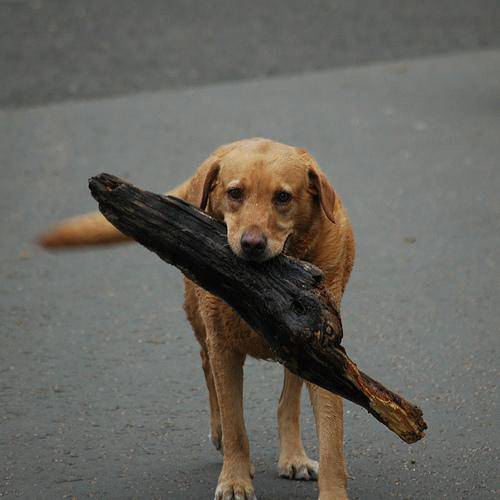

In [19]:
img = PIL.Image.open(eg_file); img

In [20]:
img.size #sz is 224, 224

(500, 500)

let's find out about all of the imagery in the training set size using a dictionary comprehension

In [21]:
size_training_imgs = {k: PIL.Image.open(PATH + '/' + k).size for k in data.trn_ds.fnames}

In [22]:
row_sz, col_sz = list(zip(*size_training_imgs.values()))

In [23]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz) #turn into numpy arrays

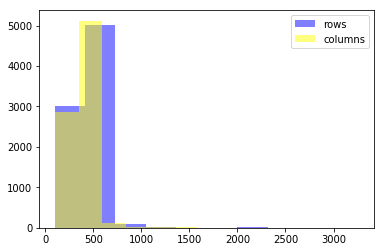

In [55]:
plt.hist(row_sz, color='blue', alpha=0.5, label='rows')
plt.hist(col_sz, color ='yellow', alpha=0.5, label='columns')
plt.legend()
plt.show()

In [25]:
row_sz_count = row_sz[row_sz<550]; col_sz_count = col_sz[col_sz<550]

In [26]:
print((len(row_sz_count)/len(row_sz))*100); print((len(col_sz_count)/len(col_sz))*100)

95.8914159941306
97.41990706774273


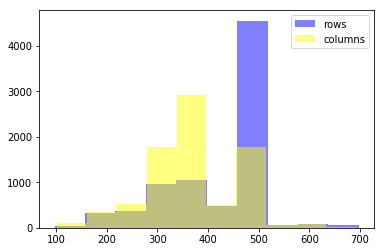

In [27]:
plt.hist(row_sz[row_sz<700], color='blue', alpha=0.5, label='rows')
plt.hist(col_sz[col_sz<700], color ='yellow', alpha=0.5, label='columns')
plt.legend()
plt.show()

Create a model function to process different batch and image sizes:<br>
- small images process super fast e.g. sz64
- if the sizes and batch sizes get too big a CUDA memory error appears. 
- for batch size try 64, if memory issue half it to 32, repeat until it works!

### 1-Enable data augmentation, and precompute=True

The reason we train with precompute=True is that it is much faster, I'm not training the earlier layers.

In [28]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}/labels.csv', test_name='test',
                                       val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

    return data if sz > 300 else data.resize(340, 'tmp')

In [29]:
data = get_data(sz, bs)

At this stage we make pre-compute = TRUE

### 2-Train last layer from precomputed activations

In [30]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [31]:
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                  
    0      1.923764   0.962036   0.778865  
    1      0.997979   0.686261   0.802838                   
    2      0.761316   0.610836   0.822896                    
    3      0.650083   0.580171   0.828767                    
    4      0.553226   0.568295   0.823386                    



[array([0.5683]), 0.8233855250646923]

Just over 80% on a pretrained model without any data augmentation or freezing! Pretty good. 

Next Augment...

In [32]:
from sklearn import metrics

In [33]:
data = get_data(sz, bs)

In [34]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [35]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      2.491322   1.282439   0.741683  
    1      1.327775   0.758472   0.810176                   



[array([0.75847]), 0.8101761254779046]

### 3-Train last layer with data augmentation (i.e. precompute=False)

In [36]:
learn.precompute=False

An epoch is one pass through the data, a cycle is however many epochs are said to be in a cycle. Cycle length 1 and epoch 1 is the same in this case. 

Cycle length is using a technique called stochastic gradient descent with restarts (SGDR). 

We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey".

In [37]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.077392   0.658015   0.821429  
    1      1.006392   0.606677   0.823386                    
    2      0.932953   0.582647   0.824853                    
    3      0.900324   0.559288   0.832681                    
    4      0.853653   0.539634   0.831703                    



[array([0.53963]), 0.8317025524296172]

save the data

In [38]:
learn.save('224_pre')

In [39]:
learn.load('224_pre')

Next, **increase size...**

In [40]:
learn.set_data(get_data(299,bs))
learn.freeze() #making sure the last layer is frozen

Now, something very cool: **increase the size of the imagery**. By starting to train on smaller images then increasing the image size at this point and continue training is so obvious and VERY effective at improving accuracy and avoiding over-fitting. 

In [41]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.811031   0.498311   0.846869  
    1      0.757856   0.480433   0.849804                    
    2      0.769275   0.470472   0.854697                    



[array([0.47047]), 0.854696682929526]

Validation loss is a lot lower than training loss = underfitting.

So cycle length of 1 is not enough. By using the cycle_mult parameter and starting with first epoch 1 cycle, second epoch 2 cycles, third epoch 4 cycles. 

### 4-Train full network with cycle_mult=2 until over-fitting

In [42]:
learn.fit(1e-2, 5, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.710088   0.465625   0.85274   
    1      0.712069   0.452295   0.85274                     
    2      0.65625    0.446272   0.860568                    
    3      0.668936   0.445514   0.863503                    
    4      0.630301   0.435751   0.867417                    
    5      0.62415    0.43231    0.86546                     
    6      0.59537    0.431321   0.863992                    
    7      0.631264   0.436614   0.860568                    
    8      0.601644   0.424287   0.867417                    
    9      0.562656   0.429016   0.864481                    
    10     0.537104   0.420277   0.86546                     
    11     0.537502   0.421591   0.867906                    
    12     0.540452   0.416537   0.869374                    
    13     0.511326   0.41364    0.867906                    
    14     0.503723   0.41604    0.866928                    
    15     0.557761   0.41

[array([0.40909]), 0.8732876740323121]

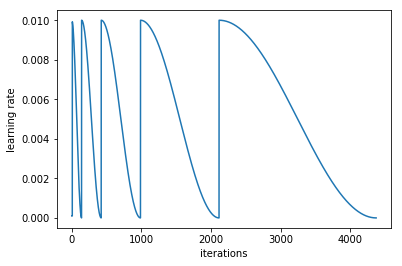

In [43]:
learn.sched.plot_lr()

This is the learning rate of the final layers using thr cycle_mult parameter. 

Next use Test Time Augmentation (TTA) to see if this improves the results

In [44]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.8762230919765166, 0.39675810000027156)

improves the model a tiny bit. 

In [45]:
learn.save('299_pre')
learn.load('299_pre')

One more fitting to see if the model got any better.

In [46]:
learn.fit(1e-2, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.444111   0.407972   0.872798  
    1      0.413425   0.406704   0.870841                    



[array([0.4067]), 0.8708414896127062]

In [47]:
learn.save('299_pre')

In [48]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.8762230919765166, 0.40014333986179224)

Decided not to unfreeze. It does not improve the model in this example. This dog breed competition is using a subset of ImageNet so we don't need to train the earlier layer. 

To improve the model even further rerun the full script with 100% of the training data, without a 20% validation set. 

In [49]:
data.classes[:5]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier']

In [50]:
data.test_ds.fnames[:5]

['test/de084b830010b6107215fef5d4a75b94.jpg',
 'test/6b423ca7020e70eb05732843c5d2bad1.jpg',
 'test/74aa7e201e0e93e13e87b986a7d31839.jpg',
 'test/a079f72193264bc5685e5d28d7372680.jpg',
 'test/583f7580fa5fec1266331fcf83b76fd6.jpg']

**Check individual predictions**

In [51]:
fn = data.val_ds.fnames[0]

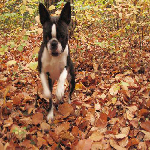

In [52]:
Image.open(PATH + '/' + fn).resize((150, 150))

In [53]:
# Method 1.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

19

In [54]:
learn.data.classes[np.argmax(preds)]

'boston_bull'

### Can I improve the results by choosing a different learning rate to lower loss?
Use lrf.learn.lr_find() then plot using learn.sched.plot_lr()

### Have a look at a confusion matrix to analyse the results